In [1]:
#Classificatore della qualità delle mele 
#!pip install xgboost
#!pip install catboost
#!pip install lightgbm
#!pip install tqdm
#!pip install ipywidgets widgetsnbextension --upgrade

In [2]:
#importiamo tutte le librerie necessarie

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import trange
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Models
#===============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
#RNN
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, linear
from keras.layers import Dense, Input, Dropout
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model, model_from_json
#
import os

In [3]:
#importiamo il data set che è costituito da 4001 esempi e 9 feature
#A_id può essere eliminato mentre Quality è la variabile dipendente
df = pd.read_csv('../datasets/apple_quality.csv')
df.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [4]:
df = df.drop("A_id",axis=1)
df.shape

(4001, 8)

In [5]:
df.dtypes

Size           float64
Weight         float64
Sweetness      float64
Crunchiness    float64
Juiciness      float64
Ripeness       float64
Acidity         object
Quality         object
dtype: object

In [6]:
#
#df["Acidity"] = df["Acidity"].astype(float)

In [7]:
#verifichiamo se ci sono elementi nulli 
df_null_values = df.isnull().sum().to_frame().rename(columns = {0:'count'})
df_null_values['%'] = (df_null_values['count'] / len(df)) * 100.
df_null_values = df_null_values.sort_values('%', ascending = False)
df_null_values

,count,%
Size,1,0.024994
Weight,1,0.024994
Sweetness,1,0.024994
Crunchiness,1,0.024994
Juiciness,1,0.024994
Ripeness,1,0.024994
Quality,1,0.024994
Acidity,0,0.000000


In [8]:
#eliminiamo le righe che contengono elementi nulli
df.dropna(inplace=True)
df.isnull().sum()

Size           0
Weight         0
Sweetness      0
Crunchiness    0
Juiciness      0
Ripeness       0
Acidity        0
Quality        0
dtype: int64

In [9]:
#Verifichiamo le distribuzioni delle feature
df["Acidity"] = df["Acidity"].astype(float)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Size,4000.0,-0.503015,1.928059,-7.151703,-1.816765,-0.513703,0.805526,6.406367
Weight,4000.0,-0.989547,1.602507,-7.149848,-2.011770,-0.984736,0.030976,5.790714
Sweetness,4000.0,-0.470479,1.943441,-6.894485,-1.738425,-0.504758,0.801922,6.374916
Crunchiness,4000.0,0.985478,1.402757,-6.055058,0.062764,0.998249,1.894234,7.619852
Juiciness,4000.0,0.512118,1.930286,-5.961897,-0.801286,0.534219,1.835976,7.364403
Ripeness,4000.0,0.498277,1.874427,-5.864599,-0.771677,0.503445,1.766212,7.237837
Acidity,4000.0,0.076877,2.110270,-7.010538,-1.377424,0.022609,1.510493,7.404736


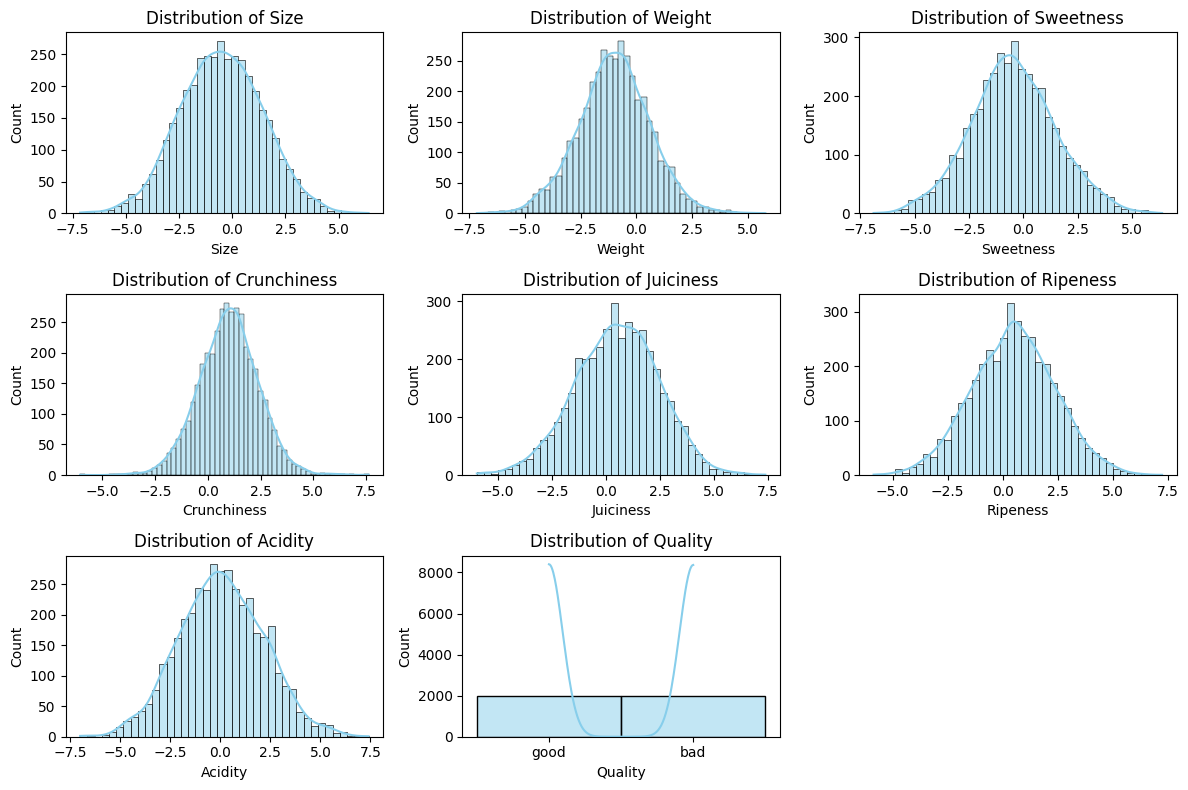

In [10]:
#vediamo la distribuzione delle variabili
plt.figure(figsize=(12, 8))
for i, col in enumerate(df.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [11]:
#testiamo la normalità delle distribuzioni
def norm_yn(nn:str):
    pv = stats.normaltest(df[nn])[1]
    alfa = "No Normal Distribution" if pv < 0.05 else "Normal Distribution"
    return alfa
cols = df.columns.to_list()[:-1]
for col in cols:
    print(f'* {col}: {norm_yn(col)}')    

* Size: Normal Distribution
* Weight: No Normal Distribution
* Sweetness: Normal Distribution
* Crunchiness: No Normal Distribution
* Juiciness: No Normal Distribution
* Ripeness: Normal Distribution
* Acidity: Normal Distribution


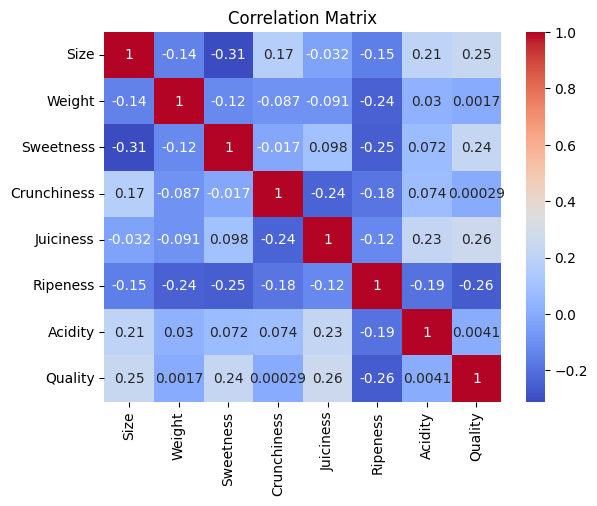

In [12]:
#i dati sono tutti distribuiti unifomemente e vi è un numero pari di casi positivi e casi negativi
#vediamo le correlazioni dopo aver trasformato la variabile Quality in numerica
#poichè non tutte le variabili hanno distribuzione normale utilizziamo la correlazione di Spearman
df['Quality'] = df['Quality'].str.replace('good', '1').str.replace('bad', '0').astype(int)
corr_matrix = df.corr(method = 'spearman')

sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()

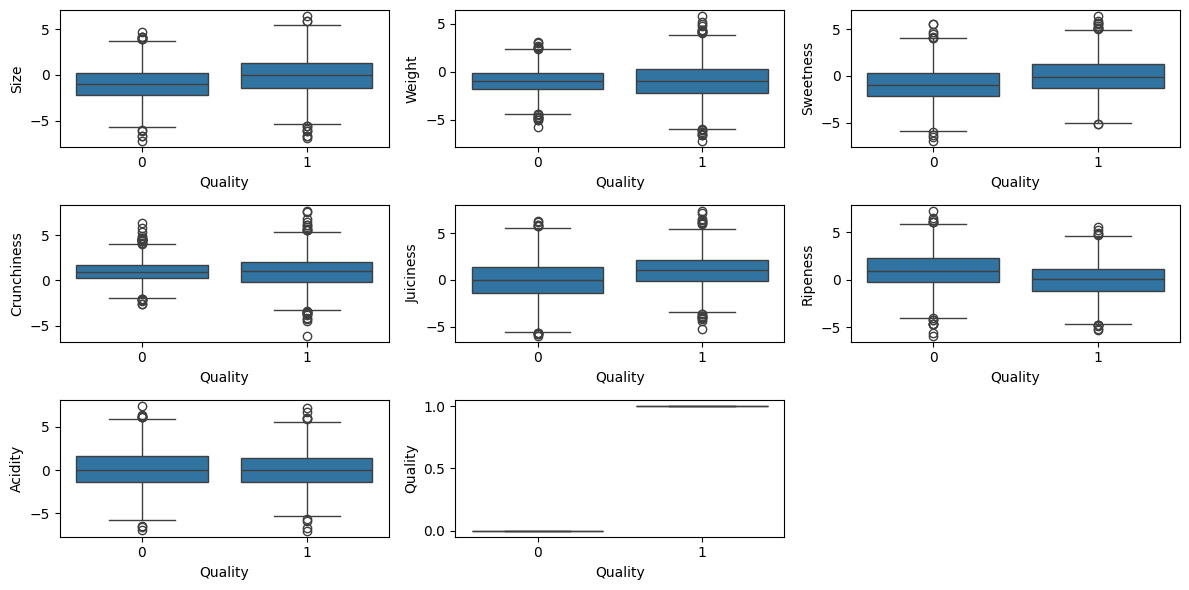

In [13]:
#Visualizing the relationship between features and target value

plt.figure(figsize = (12,6))
for i, col in enumerate(df.columns,1):
    plt.subplot(3,3,i)
    sns.boxplot(x = 'Quality', y = col, data= df)
    
plt.tight_layout()
plt.show()

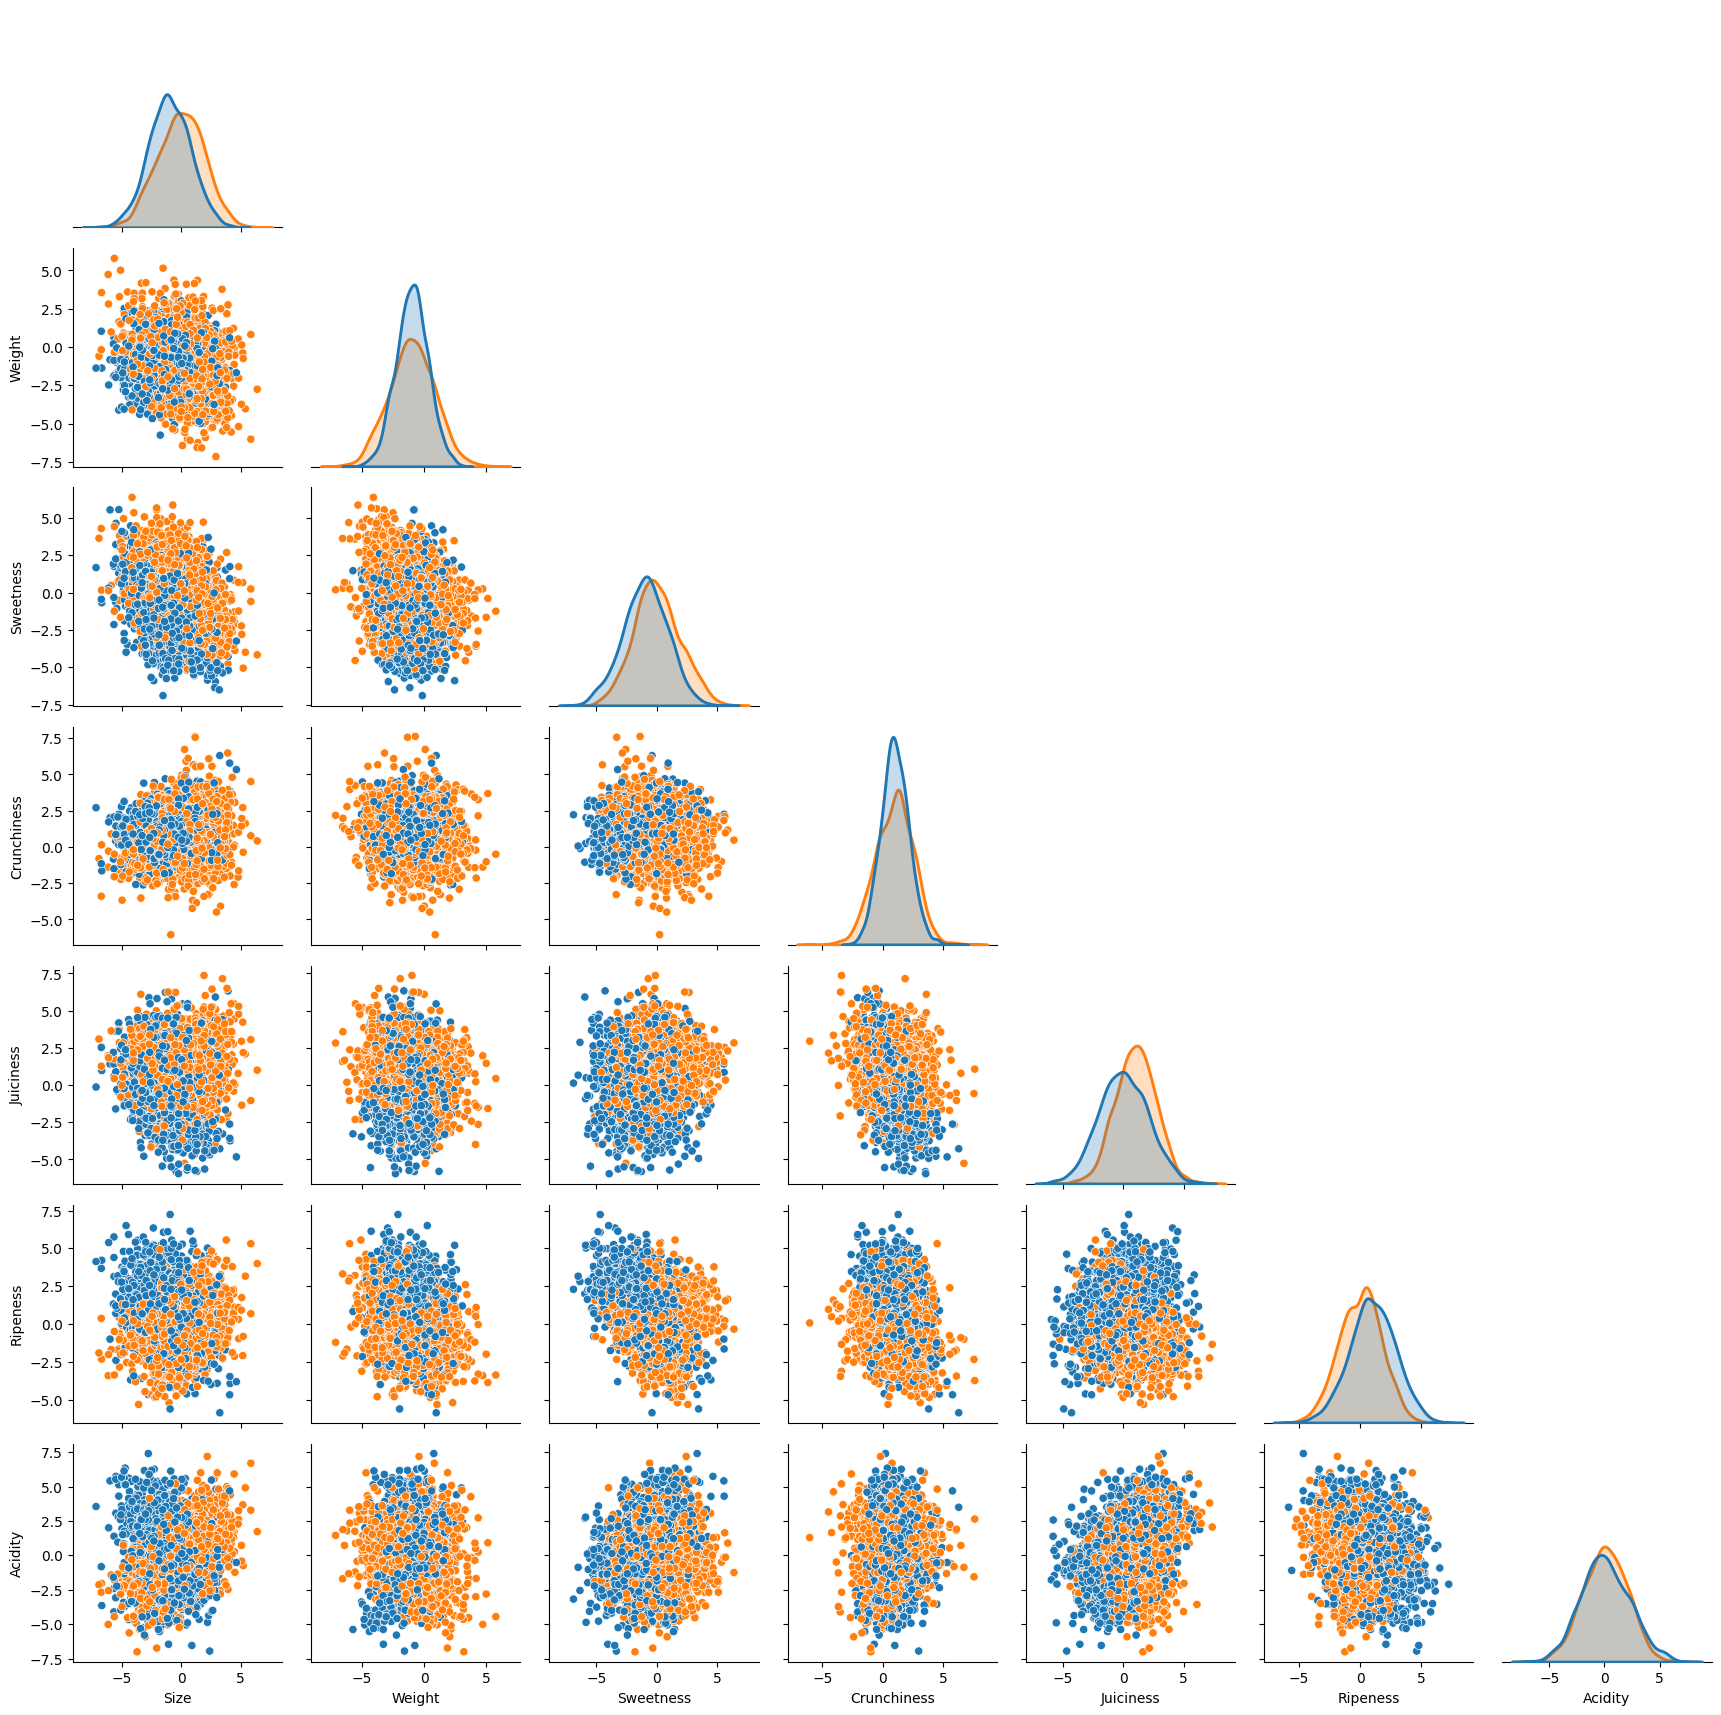

In [14]:
g = sns.PairGrid(df, hue = 'Quality', corner = True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot, fill = True, linewidth = 2.1)
plt.show()

In [15]:
#Creiamo i dataset
X = df.drop('Quality', axis =1)
y = df['Quality']

In [16]:
SEED=42
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.4, random_state = SEED)

In [17]:
X_train.shape
X_X = X_train.copy()
X_X["Quality"] = y_train
X_X = X_X.values.astype('float32')

In [18]:
X_train = X_train.values
y_train.value_counts()

Quality
0    1206
1    1194
Name: count, dtype: int64

In [19]:
y_test.value_counts()

Quality
1    810
0    790
Name: count, dtype: int64

In [20]:
#Generazione nuovo data set con GAN
len_ex = 30
def adam_optimizer():
    return Adam(learning_rate=0.00005, beta_1=0.65)

# generatore
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=128, input_dim=len_ex, activation='selu'))
    
    generator.add(Dense(units=64, activation='selu'))

    generator.add(Dense(units=32, activation='selu'))
    
    generator.add(Dense(units=8, activation='linear'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

g = create_generator()

# discriminatore
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=64, input_dim=8, activation='selu'))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(units=32, activation='selu'))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=16, activation='selu'))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

d = create_discriminator()

# GAN (con Adam parametri di default)
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(len_ex,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return gan

gan = create_gan(d, g)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 sequential (Sequential)     (None, 8)                 14568     
                                                                 
 sequential_1 (Sequential)   (None, 1)                 3201      
                                                                 
Total params: 17,769
Trainable params: 14,568
Non-trainable params: 3,201
_________________________________________________________________


In [21]:
noise_min = 0 # centro della distribuzione dei dati
noise_max = 1.8 # dvs

#training GAN
def training(X_train, epochs, batch_size, epoche_addestramento, gen_):
    # Creazione modello:
    # prima generatore e discriminatore quindi la GAN
    generator = create_generator()
    discriminator = create_discriminator()
    gan = create_gan(discriminator, generator)
    tot_epoche = epoche_addestramento + epochs
    minloss = 0.5*batch_size
    pre_epoca = 0
    old_epoca = 0
    for e in range(1, epochs + 1):
        losses = 0
        epoca_attuale = e + epoche_addestramento
        t = trange(batch_size, desc='', leave=True)
        for b in t:
            msg = 'Epoca ' + str(epoca_attuale) + '/' + str(tot_epoche)
            msg += ' - Batch ' + str(b + 1) + '/' + str(batch_size)
            msg += ' - Loss ' + str(losses / (b + 1))[:6] + ' '
            t.set_description(msg)
            t.refresh()
            # generazione di "disturbo" come input per il generatore
            noise = np.random.normal(noise_min, noise_max, [batch_size, len_ex])
            
            # generazione di input fake
            generated_input = generator.predict(noise)
            
            # recupero di un subset casuale di righe dal dataset reale
            input_batch = X_train[np.random.randint(low=0, high=X_train.shape[0], size=batch_size)]
            
            # costruzione di batch di input reali e generati 
            X = np.concatenate([input_batch, generated_input])
            
            # etichette per i dati reali e generati
            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 0.9
            
            # training del discriminatore su dati reali e generati
            # prima dell'addestramento della GAN 
            discriminator.trainable = True
            losses += discriminator.train_on_batch(X, y_dis)
            
            # Creazione di un dataset utile al generatore
            noise = np.random.normal(noise_min, noise_max, [batch_size, len_ex])
            y_gen = np.ones(batch_size)
            
            # addestramento della GAN tramite il blocco 
            # dell'adddestramento del discriminatore
            discriminator.trainable = False
            
            # addestramento della GAN (discriminatore bloccato,
            # generatore che si addestra ad "ingannare" il
            # discriminatore)
            gan.train_on_batch(noise, y_gen)
        
        if losses < minloss:
           minloss = losses
           pre_epoca = epoca_attuale
           generator.save_weights("generator.h5")
           discriminator.save_weights("discriminator.h5")    
           gan.save_weights("gan.h5")  
           #visualizza l'andamento
           if epoca_attuale - old_epoca > 20:
            old_epoca = epoca_attuale
            noise = np.random.normal(noise_min, noise_max, [gen_, len_ex])
            generated_input = generator.predict(noise)
            dfx = pd.DataFrame(generated_input)
            dfx = dfx.set_axis(list(df), axis=1)
            dfx.loc[dfx.Quality <=0.5, "Quality"] = 0
            dfx.loc[dfx.Quality >0.5, "Quality"] = 1
            plt.figure(figsize=(12, 8))
            for i, col in enumerate(dfx.columns, 1):
             plt.subplot(3, 3, i)
             sns.histplot(dfx[col], kde=True, color='skyblue')
             plt.title(f'Distribution of {col}')
             plt.tight_layout()
             plt.show()
        if epoca_attuale - pre_epoca > 150:
           if pre_epoca==0:
             generator.save_weights("generator.h5")
             discriminator.save_weights("discriminator.h5")    
             gan.save_weights("gan.h5")  

           break 
        # ogni tot epoche vengono creati dei dati per
        # visualizzare il comportamento del generatore
        if epoca_attuale == 1 or epoca_attuale == 5 or epoca_attuale == 10 or epoca_attuale % 20 == 0:
            print(e)
            #plot_generated_images(e, generator)
        
    noise = np.random.normal(noise_min, noise_max, [gen_, len_ex])
    generated_input = generator.predict(noise)
    return epoche_addestramento + epochs, generated_input

In [22]:
# addestramento GAN
epoche_addestramento = 0
epoche = 500
genera = 5000
# Modello ->> file json
model_json = g.to_json()
with open("generator.json", "w") as json_file:
     json_file.write(model_json)
model_json = d.to_json()
with open("discriminator.json", "w") as json_file:
     json_file.write(model_json)
model_json = gan.to_json()
with open("gan.json", "w") as json_file:
     json_file.write(model_json)

In [23]:
epoche_addestramento, generated_input  = training(X_X, epochs=epoche, batch_size=64, epoche_addestramento=epoche_addestramento, gen_=genera)

  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step
1


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step
5


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step
10


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step
20


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step
40


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step
60


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step
80


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step
100


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step
120


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step
140


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/64 [00:00<?, ?it/s]

157/157 [==============================] - 0s 2ms/step


In [24]:
dfx = pd.DataFrame(generated_input)
dfx = dfx.set_axis(list(df), axis=1)
qmid = dfx["Quality"].mean()
dfx.loc[dfx.Quality <=qmid, "Quality"] = 0
dfx.loc[dfx.Quality >qmid, "Quality"] = 1
dfx.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Size,5000.0,-0.373164,2.039028,-6.125351,-1.832397,-0.376298,1.099010,5.622042
Weight,5000.0,-0.969648,1.369253,-6.635204,-1.817248,-0.863728,-0.028159,3.200402
Sweetness,5000.0,-0.434483,1.953763,-6.289081,-1.841624,-0.499754,0.954229,5.480255
Crunchiness,5000.0,0.985919,1.456394,-3.878130,-0.035739,0.922267,1.962841,7.381851
Juiciness,5000.0,0.418165,1.750010,-5.116310,-0.813727,0.391622,1.589594,6.851594
Ripeness,5000.0,0.560242,1.854120,-4.756474,-0.758154,0.517662,1.828719,6.821434
Acidity,5000.0,0.152680,2.052304,-6.551802,-1.315309,0.164821,1.561512,7.118916
Quality,5000.0,0.471600,0.499243,0.000000,0.000000,0.000000,1.000000,1.000000


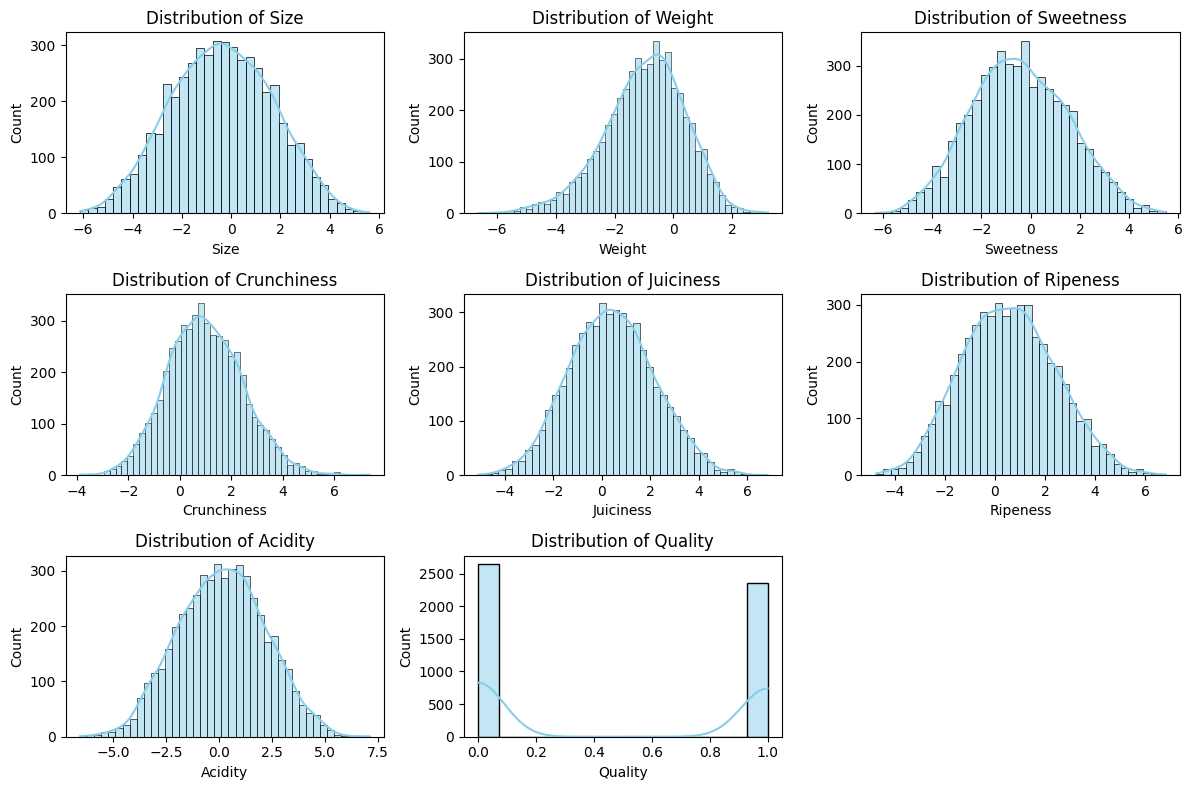

In [25]:
#vediamo la distribuzione delle variabili
plt.figure(figsize=(12, 8))
for i, col in enumerate(dfx.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(dfx[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [26]:
# Carichiamo il file json
json_file = open('generator.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
generator = model_from_json(loaded_model_json)
# Carichiamo i pesi
generator.load_weights("generator.h5")
print("Loaded model from disk")

Loaded model from disk


In [27]:
# Rivalutiamo il modello
generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
noise = np.random.normal(noise_min, noise_max, [genera, len_ex])
generated_input = generator.predict(noise)

157/157 [==============================] - 0s 2ms/step


In [28]:
#aggiungo i dati sintetici al dataset originario
dfx = pd.DataFrame(generated_input)
dfx = dfx.set_axis(list(df), axis=1)
qmid = dfx["Quality"].mean()
dfx.loc[dfx.Quality < qmid, "Quality"] = 0
dfx.loc[dfx.Quality >= qmid, "Quality"] = 1
X = dfx.drop('Quality', axis =1).values
y = dfx['Quality'].values
X_train = np.concatenate([X_train, X])
y_train = np.concatenate([y_train, y])

In [29]:
e1 = LGBMClassifier(random_state = SEED, n_jobs = -1)
e2 = CatBoostClassifier(random_state = SEED, verbose = 0)
estimators = [('lgbm',e1), ('cb',e2)]
#Modelli da testare
clf1 = VotingClassifier(estimators, voting = 'soft', n_jobs = -1)
clf2 = LogisticRegression(random_state = SEED, n_jobs = -1)
clf3 = RandomForestClassifier(random_state = SEED, n_jobs = -1)
clf4 = ExtraTreesClassifier(bootstrap = True, n_jobs = -1, random_state = SEED)
clf5 = XGBClassifier(random_state = SEED, n_jobs = -1)
clf6 = LGBMClassifier(random_state = SEED, n_jobs = -1)
clf7 = CatBoostClassifier(random_state = SEED, verbose = 0)
clf8 = SVC(probability = True, random_state = SEED)
clf9 = GaussianNB()
MODELS = [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9]

In [30]:
# Training!!!
#=====================================================================
accuracy_train = {}
accuracy_test = {}
report_a = {}
for model in tqdm(MODELS):
    name = type(model).__name__
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    accuracy_train[name] = accuracy_score(y_train, y_pred_train)
    accuracy_test[name] = accuracy_score(y_test, y_pred_test)
    report_a[name] = classification_report(y_test,y_pred_test)
    print(f'* {name} finished. Accuratezza train {accuracy_train[name]} - Accuratezza test {accuracy_test[name]}')

 11%|█████████▎                                                                          | 1/9 [00:07<00:57,  7.17s/it]

* VotingClassifier finished. Accuratezza train 0.8532432432432432 - Accuratezza test 0.83625


C:\Users\pasma\anaconda3\envs\tensorflowgpu\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
 22%|██████████████████▋                                                                 | 2/9 [00:07<00:23,  3.35s/it]

* LogisticRegression finished. Accuratezza train 0.7012162162162162 - Accuratezza test 0.725


C:\Users\pasma\anaconda3\envs\tensorflowgpu\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
 33%|████████████████████████████                                                        | 3/9 [00:09<00:15,  2.52s/it]

* RandomForestClassifier finished. Accuratezza train 1.0 - Accuratezza test 0.833125


C:\Users\pasma\anaconda3\envs\tensorflowgpu\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:10<00:04,  1.22s/it]

* ExtraTreesClassifier finished. Accuratezza train 1.0 - Accuratezza test 0.83
* XGBClassifier finished. Accuratezza train 0.9459459459459459 - Accuratezza test 0.809375


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:10<00:02,  1.18it/s]

[LightGBM] [Info] Number of positive: 3491, number of negative: 3909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 7400, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.471757 -> initscore=-0.113093
[LightGBM] [Info] Start training from score -0.113093
* LGBMClassifier finished. Accuratezza train 0.8567567567567568 - Accuratezza test 0.83


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:14<00:03,  1.91s/it]

* CatBoostClassifier finished. Accuratezza train 0.845 - Accuratezza test 0.84


C:\Users\pasma\anaconda3\envs\tensorflowgpu\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:27<00:05,  5.39s/it]C:\Users\pasma\anaconda3\envs\tensorflowgpu\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.04s/it]

* SVC finished. Accuratezza train 0.7775675675675676 - Accuratezza test 0.843125
* GaussianNB finished. Accuratezza train 0.6891891891891891 - Accuratezza test 0.695625


In [31]:
import operator
winner_as = max(accuracy_train.items(), key=operator.itemgetter(1))[0]
winner_is = max(accuracy_test.items(), key=operator.itemgetter(1))[0]
print(f'* Miglior Modello train {winner_as}')
print(f'* Miglior Modello test  {winner_is}')
print(accuracy_test[winner_is])
print(report_a[winner_is])

* Miglior Modello train RandomForestClassifier
* Miglior Modello test  SVC
0.843125
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       790
           1       0.90      0.78      0.83       810

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.84      1600
weighted avg       0.85      0.84      0.84      1600



In [32]:
#Rete neurale
model_checkpoint = ModelCheckpoint('best_model.h5', monitor = 'val_loss', save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 25, restore_best_weights = True)
lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', patience = 10, factor = 0.01, min_lr = 0.00000000001)

In [33]:
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

input_layer = Input(shape = (X_train.shape[1], )) 
layer1 = Dense(units = 14, activation = 'relu')(input_layer) 
layer2 = Dense(units = 10, activation = 'relu')(layer1) 
layer3 = Dense(units = 7, activation = 'relu')(layer2) 
output_layer = Dense(units = 1, activation = 'sigmoid')(layer3)

model = Model(inputs = input_layer, outputs = output_layer, name = 'MLP')

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), 
              loss = tf.keras.losses.BinaryCrossentropy(), 
              metrics = "accuracy")

C:\Users\pasma\anaconda3\envs\tensorflowgpu\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [36]:
tf.random.set_seed(SEED)

history = model.fit(x = X_train, y = y_train, 
                    batch_size = 64, epochs = 500, verbose = 1, 
                    callbacks = [model_checkpoint, early_stopping, lr_reduce], 
                    shuffle = True,
                    validation_data = (X_test, y_test.values))

Epoch 1/500
116/116 [==============================] - 1s 11ms/step - loss: 0.4413 - accuracy: 0.7896 - val_loss: 0.3317 - val_accuracy: 0.8612 - lr: 1.0000e-10
Epoch 2/500
116/116 [==============================] - 1s 9ms/step - loss: 0.4413 - accuracy: 0.7896 - val_loss: 0.3317 - val_accuracy: 0.8612 - lr: 1.0000e-10
Epoch 3/500
116/116 [==============================] - 1s 9ms/step - loss: 0.4413 - accuracy: 0.7896 - val_loss: 0.3317 - val_accuracy: 0.8612 - lr: 1.0000e-10
Epoch 4/500
116/116 [==============================] - 1s 9ms/step - loss: 0.4413 - accuracy: 0.7896 - val_loss: 0.3317 - val_accuracy: 0.8612 - lr: 1.0000e-10
Epoch 5/500
116/116 [==============================] - 1s 9ms/step - loss: 0.4413 - accuracy: 0.7896 - val_loss: 0.3317 - val_accuracy: 0.8612 - lr: 1.0000e-10
Epoch 6/500
116/116 [==============================] - 1s 9ms/step - loss: 0.4413 - accuracy: 0.7896 - val_loss: 0.3317 - val_accuracy: 0.8612 - lr: 1.0000e-10
Epoch 7/500
116/116 [==================

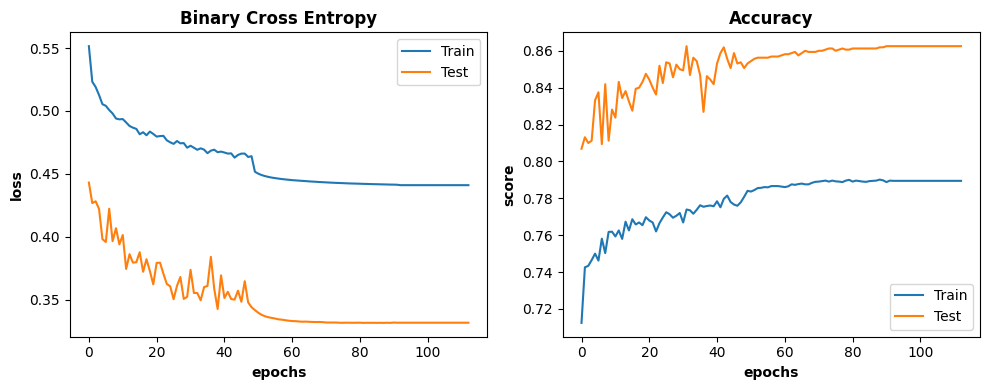

In [35]:
fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
axs[0].plot(history.history['loss'], label = 'Train')
axs[0].plot(history.history['val_loss'], label = 'Test')
axs[0].set_title("Binary Cross Entropy", fontsize = 12, fontweight = "bold")
axs[0].set_xlabel("epochs", fontsize = 10, fontweight = "bold")
axs[0].set_ylabel("loss", fontsize = 10, fontweight = "bold")
axs[0].legend()

axs[1].plot(history.history['accuracy'], label = 'Train')
axs[1].plot(history.history['val_accuracy'], label = 'Test')
axs[1].set_title("Accuracy", fontsize = 12, fontweight = "bold")
axs[1].set_xlabel("epochs", fontsize = 10, fontweight = "bold")
axs[1].set_ylabel("score", fontsize = 10, fontweight = "bold")
axs[1].legend()

fig.tight_layout()
plt.show()